In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy import stats
from typing import Dict, Tuple, List
import warnings

In [4]:
# Global configurations
code_directory = '/Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/code'
os.chdir(code_directory)
base_path_results = '../results'

In [5]:
def inspect_region_features():
        
    # Load data
    print("Loading data...")
    hup_region_features = pd.read_csv(os.path.join(base_path_results, 'ge_go_hup_region_features.csv'))
    mni_region_features = pd.read_csv(os.path.join(base_path_results, 'mni_region_features.csv'))
    
    # Print basic information
    print("\nDataset Overview:")
    print("=" * 50)
    print(f"HUP Region Features shape: {hup_region_features.shape}")
    print(f"MNI Region Features shape: {mni_region_features.shape}")
    
    # Inspect columns
    print("\nColumns in datasets:")
    print("=" * 50)
    print("HUP columns:", hup_region_features.columns.tolist())
    print("MNI columns:", mni_region_features.columns.tolist())
    
    # Feature columns (excluding metadata columns)
    feature_columns = [
        'deltaRel_mean', 
        'thetaRel_mean', 
        'alphaRel_mean', 
        'betaRel_mean',
        'gammaRel_mean',
        'entropy_1min_mean',
        'entropy_fullts_mean'
    ]
    
    # Analyze patient and region coverage
    print("\nPatient and Region Coverage:")
    print("=" * 50)
    print("HUP Dataset:")
    print(f"Number of unique patients: {hup_region_features['patient_id'].nunique()}")
    print(f"Number of unique regions: {hup_region_features['roi'].nunique()}")
    print("\nMNI Dataset:")
    print(f"Number of unique patients: {mni_region_features['patient_id'].nunique()}")
    print(f"Number of unique regions: {mni_region_features['roi'].nunique()}")
    
    # Analyze common regions
    common_regions = set(hup_region_features['roi'].unique()) & set(mni_region_features['roi'].unique())
    print(f"\nNumber of common regions between datasets: {len(common_regions)}")
    
    # Feature statistics by region
    print("\nFeature Statistics by Dataset:")
    print("=" * 50)
    
    for dataset_name, dataset in [("HUP", hup_region_features), ("MNI", mni_region_features)]:
        print(f"\n{dataset_name} Dataset Feature Statistics:")
        feature_stats = dataset[feature_columns].agg(['mean', 'std', 'min', 'max'])
        print(feature_stats)
    
    # Analyze patient counts per region
    print("\nPatient Counts per Region:")
    print("=" * 50)
    
    def get_region_patient_counts(df):
        return df.groupby('roi')['patient_id'].nunique().sort_values(ascending=False)
    
    print("\nHUP Dataset - Top 10 regions by patient count:")
    print(get_region_patient_counts(hup_region_features).head(10))
    
    print("\nMNI Dataset - Top 10 regions by patient count:")
    print(get_region_patient_counts(mni_region_features).head(10))
    
    # Identify regions with low patient counts
    min_patients = 5  # Threshold for minimum patients
    
    print(f"\nRegions with <{min_patients} patients:")
    print("=" * 50)
    
    for dataset_name, dataset in [("HUP", hup_region_features), ("MNI", mni_region_features)]:
        patient_counts = get_region_patient_counts(dataset)
        low_count_regions = patient_counts[patient_counts < min_patients]
        print(f"\n{dataset_name} Dataset:")
        print(low_count_regions)
    
    # Save detailed analysis to file
    output_file = os.path.join(base_path_results, 'region_features_analysis.txt')
    print(f"\nSaving to: {output_file}")
    
    with open(output_file, 'w') as f:
        f.write("Region Features Analysis\n")
        f.write("=" * 50 + "\n\n")
        
        # Write patient counts per region
        f.write("Patient Counts per Region:\n")
        f.write("-" * 30 + "\n")
        f.write("\nHUP Dataset:\n")
        f.write(get_region_patient_counts(hup_region_features).to_string())
        f.write("\n\nMNI Dataset:\n")
        f.write(get_region_patient_counts(mni_region_features).to_string())
        
        # Write feature correlations
        f.write("\n\nFeature Correlations:\n")
        f.write("-" * 30 + "\n")
        f.write("\nHUP Dataset:\n")
        f.write(hup_region_features[feature_columns].corr().to_string())
        f.write("\n\nMNI Dataset:\n")
        f.write(mni_region_features[feature_columns].corr().to_string())

# if __name__ == "__main__":
#     inspect_region_features()

Cohen's d with bootstrap confidence intervals

# For each iteration:
1. Resample from group1 with replacement
2. Resample from group2 with replacement
3. Compute Cohen's d for these resamples
4. Store the result

# After all iterations:
5. Sort the bootstrap estimates
6. Take percentiles for confidence intervals
   - For 95% CI: 2.5th and 97.5th percentiles

In [16]:
def visualize_effect_sizes(effect_sizes: Dict, 
                          confidence_intervals: Dict,
                          output_path: str = None):
    """
    Create visualizations for effect sizes and confidence intervals.
    """
    # Convert dictionaries to DataFrame
    df_list = []
    for region in effect_sizes:
        for feature in effect_sizes[region]:
            d = effect_sizes[region][feature]
            ci_lower, ci_upper = confidence_intervals[region][feature]
            df_list.append({
                'Region': region,
                'Feature': feature,
                'Cohens_d': d,
                'CI_lower': ci_lower,
                'CI_upper': ci_upper
            })
    
    df = pd.DataFrame(df_list)
    
    # Define consistent feature ordering and mapping
    feature_order = [
        'deltaRel_mean', 
        'thetaRel_mean', 
        'alphaRel_mean', 
        'betaRel_mean',
        'gammaRel_mean', 
        'entropy_1min_mean', 
        'entropy_fullts_mean'
    ]
    
    feature_name_mapping = {
        'deltaRel_mean': 'delta',
        'thetaRel_mean': 'theta', 
        'alphaRel_mean': 'alpha',
        'betaRel_mean': 'beta',
        'gammaRel_mean': 'gamma',
        'entropy_1min_mean': 'entropy 1min',
        'entropy_fullts_mean': 'entropy full'
    }
    
    # 1. Heatmap of effect sizes
    plt.figure(figsize=(12, 8))
    
    # Rename columns for display
    heatmap_data = df.pivot(index='Region', columns='Feature', values='Cohens_d')
    # Reorder columns according to feature_order
    heatmap_data = heatmap_data[feature_order]
    heatmap_data.columns = [feature_name_mapping[col] for col in heatmap_data.columns]
    
    # Create heatmap
    sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, 
                vmin=-1.5, vmax=1.5, annot=True, fmt='.2f',
                xticklabels=True, yticklabels=True)
    
    plt.xticks(rotation=0)
    plt.title("Cohen's d Effect Sizes: HUP vs MNI")
    plt.tight_layout()
    
    # 2. Forest plot with region names and ordered features
    plt.figure(figsize=(15, 12))  # Increased figure size to accommodate region names
    
    # Get unique regions and create y-axis positions
    unique_regions = df['Region'].unique()
    y_positions = np.arange(len(unique_regions))
    
    # Create color cycle for features
    colors = plt.cm.tab10(np.linspace(0, 1, len(feature_order)))
    
    for idx, feature in enumerate(feature_order):
        feature_data = df[df['Feature'] == feature].copy()
        # Map regions to y-positions
        feature_data['y_pos'] = feature_data['Region'].map({region: i for i, region in enumerate(unique_regions)})
        
        plt.errorbar(feature_data['Cohens_d'], 
                    feature_data['y_pos'],
                    xerr=[feature_data['Cohens_d'] - feature_data['CI_lower'],
                          feature_data['CI_upper'] - feature_data['Cohens_d']],
                    fmt='o', label=feature_name_mapping[feature], 
                    alpha=0.7, color=colors[idx])
    
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.3)
    plt.xlabel("Cohen's d")
    plt.yticks(y_positions, unique_regions, fontsize=8)
    plt.title("Effect Sizes with 95% Confidence Intervals\n(Positive = Higher in HUP, Negative = Higher in MNI)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if output_path:
        plt.savefig(f"{output_path}/cohens_d_effect_sizes_heatmap.png", dpi=300, bbox_inches='tight')

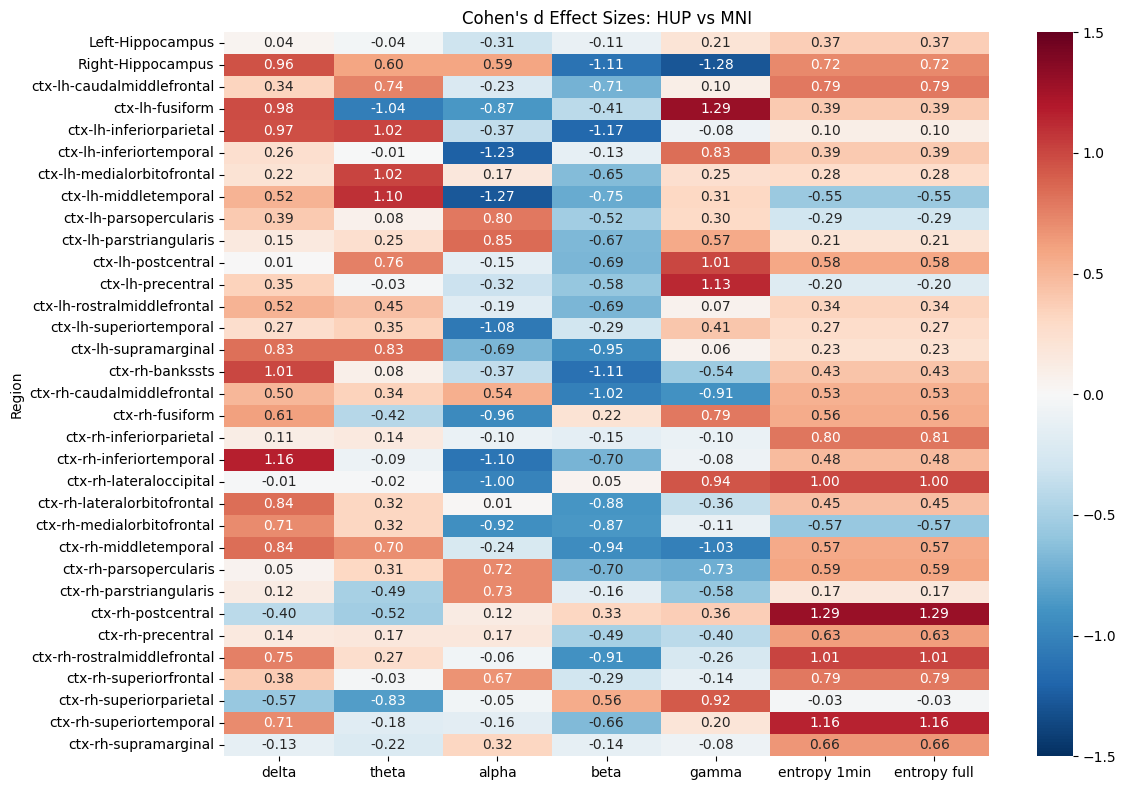

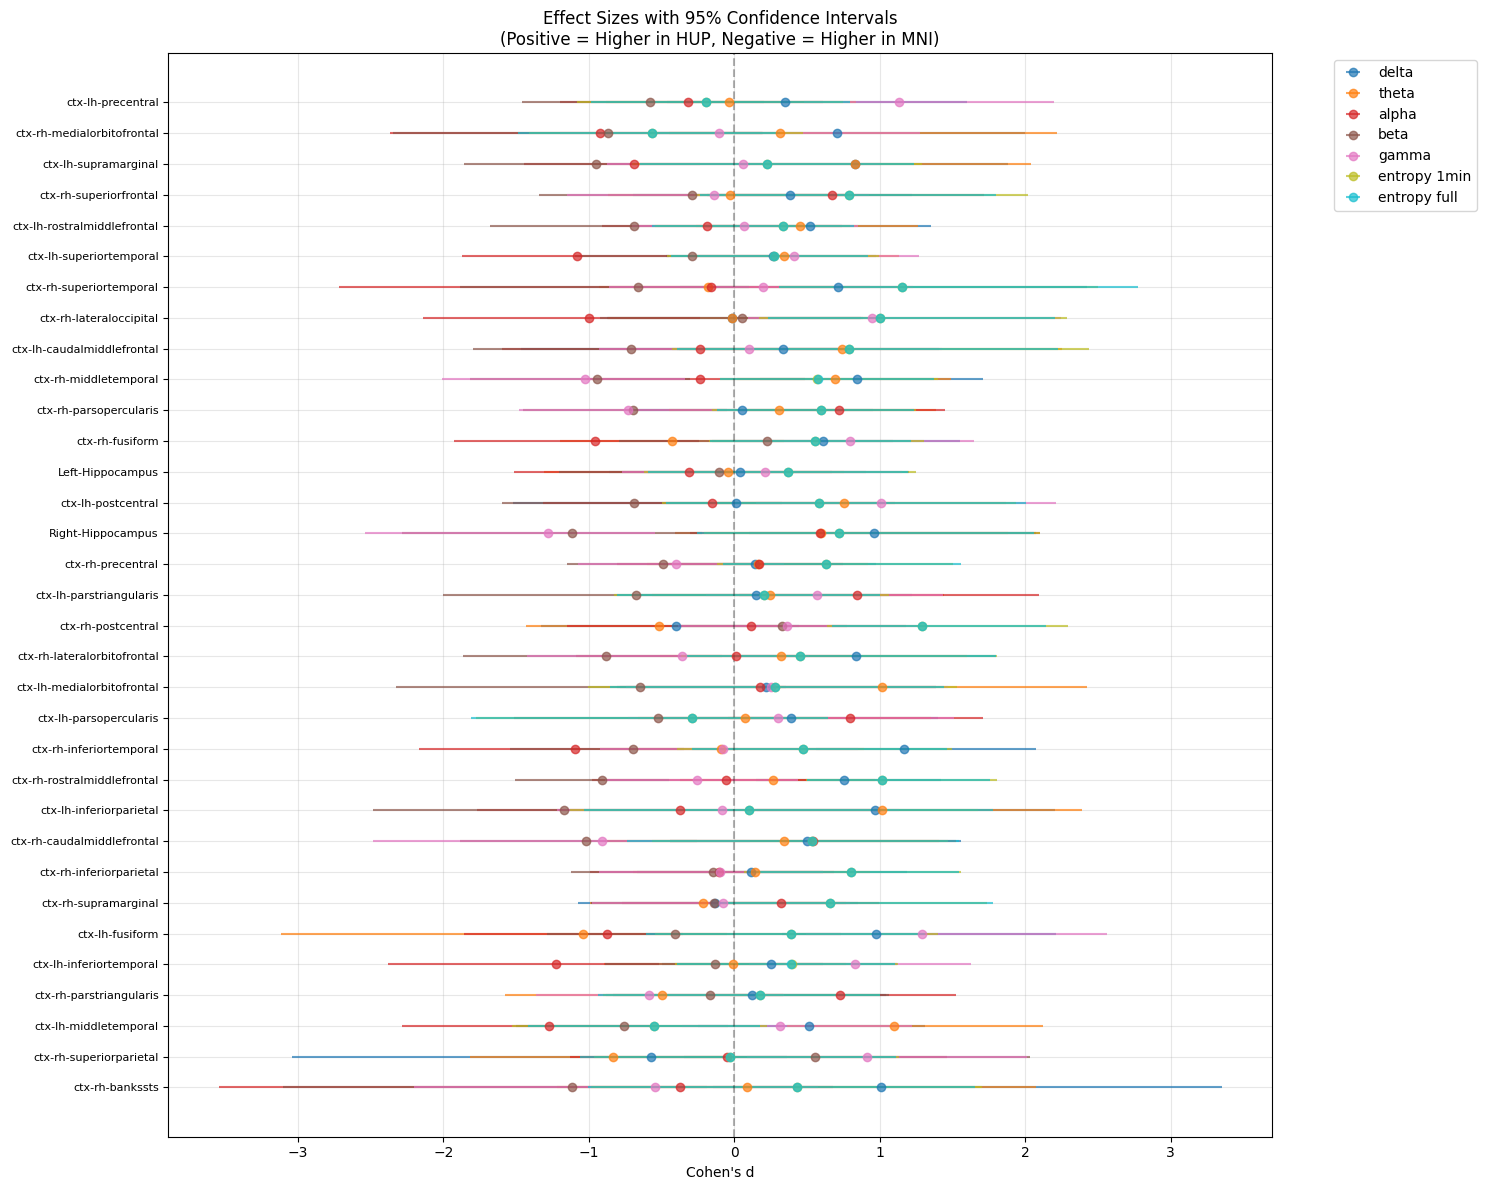

In [17]:
def main():
    """
    Main function to run the analysis.
    """
    # Load data (assuming these are already loaded as per your script)
    hup_region_features = pd.read_csv(os.path.join(base_path_results, 'ge_go_hup_region_features.csv'))
    mni_region_features = pd.read_csv(os.path.join(base_path_results, 'mni_region_features.csv'))
    
    # Compute effect sizes and confidence intervals
    effect_sizes, confidence_intervals = analyze_effect_sizes(
        hup_region_features, 
        mni_region_features,
        min_patients=5
    )
    
    # Create visualizations
    visualize_effect_sizes(
        effect_sizes, 
        confidence_intervals,
        output_path=base_path_results
    )
    
    # Save numerical results
    results_df = []
    for region in effect_sizes:
        for feature in effect_sizes[region]:
            d = effect_sizes[region][feature]
            ci_lower, ci_upper = confidence_intervals[region][feature]
            results_df.append({
                'Region': region,
                'Feature': feature,
                'Cohens_d': d,
                'CI_lower': ci_lower,
                'CI_upper': ci_upper
            })
    
    results_df = pd.DataFrame(results_df)
    results_df.to_csv(os.path.join(base_path_results, 'cohens_d_results.csv'), index=False)

if __name__ == "__main__":
    main()